# Description

This jupyter script will help to determine the thresholds in the demultiplexing and trimming procedure.

Including:
    
1. Edit distance, direction and location of confident barcode.
2. Edit distance of confident edge-linker.
3. Edit distance of inner-linker for potential chimeric reads.

The `mtxdir` contains the FBILR outputs (see `snakemake.smk`).

In [5]:
import os
import glob
import gzip
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

mtxdir = "/home/chenzonggui/1_baixiuzhen/1_NanoStrandseq/results/demux/fbilr"

runs = [
    "20220708_GM12878",
    "20220708_GM12878R2",
    "20220817_HG001",
    "20220915_P1",
    "20220916_P1",
    "20220916_P2"]

# Confident barcode

## 1. Edit distance of barcode

--------------------------------------------------------------------------------
Run: 20220708_GM12878
% of perfect barcode:	42.16	13.88	11.33	7.07	4.71	3.34	4.47	11.28	1.74	0.01
% of perfect barcode:	47.32	14.07	9.0	6.24	4.27	2.9	2.68	5.98	7.35	0.19


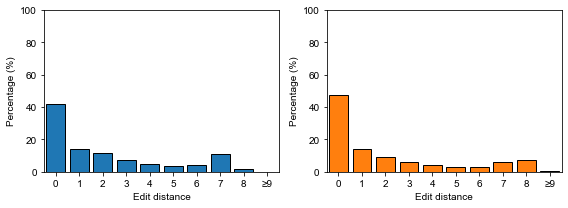

--------------------------------------------------------------------------------
Run: 20220708_GM12878R2
% of perfect barcode:	46.36	13.69	10.63	6.46	4.31	3.1	4.17	10.13	1.14	0.01
% of perfect barcode:	51.57	13.39	8.24	5.81	3.96	2.68	2.47	5.29	6.44	0.15


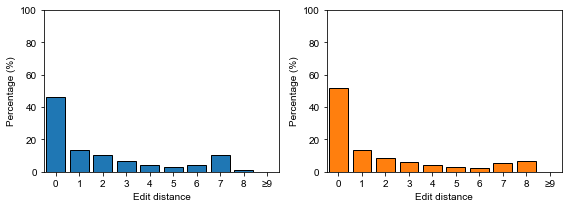

--------------------------------------------------------------------------------
Run: 20220817_HG001
% of perfect barcode:	39.29	12.64	9.78	6.22	4.24	3.62	6.39	14.62	3.2	0.02
% of perfect barcode:	42.32	12.37	8.09	5.69	4.05	2.84	2.82	7.42	13.49	0.92


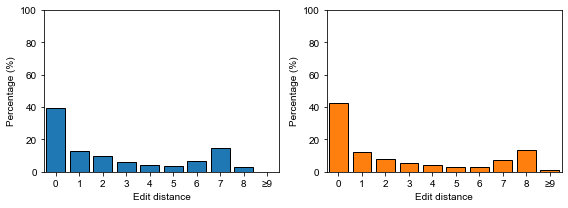

--------------------------------------------------------------------------------
Run: 20220915_P1
% of perfect barcode:	55.99	13.1	9.8	5.43	3.32	2.17	2.38	7.1	0.7	0.01
% of perfect barcode:	60.54	12.66	7.29	4.8	3.1	1.95	1.67	3.39	4.46	0.13


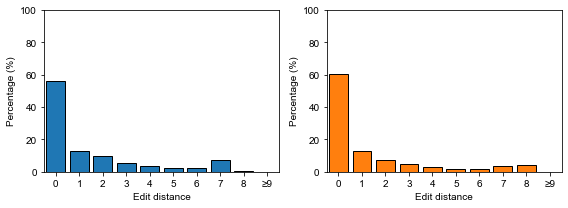

--------------------------------------------------------------------------------
Run: 20220916_P1
% of perfect barcode:	54.88	13.06	9.4	5.39	3.32	2.2	2.79	8.19	0.77	0.0
% of perfect barcode:	59.37	12.7	7.27	4.73	3.03	1.9	1.7	3.84	5.27	0.19


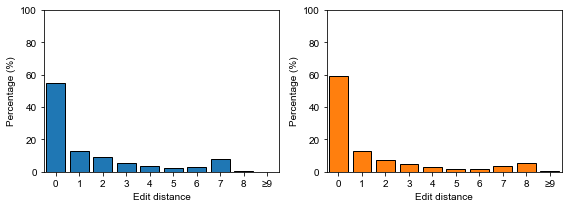

--------------------------------------------------------------------------------
Run: 20220916_P2
% of perfect barcode:	55.42	13.29	10.04	5.64	3.51	2.32	2.34	6.73	0.72	0.01
% of perfect barcode:	60.44	12.9	7.43	4.88	3.15	2.02	1.7	3.25	4.12	0.11


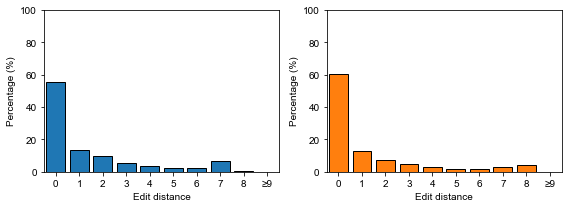

In [34]:
max_ed = 9

for run in runs:
    print("-" * 80)
    print("Run:", run)
    
    path = os.path.join(mtxdir, "%s.stats.tsv.gz" % run)
    counter1 = defaultdict(int)
    counter2 = defaultdict(int)
    with gzip.open(path, "rt") as f:
        for line in f:
            row = line.strip("\n").split("\t")
            ed1, ed2, count = int(row[3]), int(row[7]), int(row[8])
            ed1, ed2 = min(ed1, max_ed), min(ed2, max_ed)
            counter1[ed1] += count
            counter2[ed2] += count
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    for i in range(2):
        counter = counter1 if i == 0 else counter2
        plt.sca(axs[i])
        xs = np.arange(max_ed + 1)
        xticks = list(map(str, xs))
        xticks[-1] = "≥%s" % xticks[-1]
        ys = [counter[x] for x in xs]
        ys = np.array(ys) * 100 / sum(counter.values())
        print("% of perfect barcode:", *[round(y, 2) for y in ys], sep="\t")
        plt.bar(xs, ys, edgecolor="black", color="C%d" % i)
        plt.xlabel("Edit distance")
        plt.ylabel("Percentage (%)")
        plt.xticks(xs, xticks)
        plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
        plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()
    plt.close() 

## 2. Direction and location distribution

--------------------------------------------------------------------------------
20220708_GM12878
1st barcode


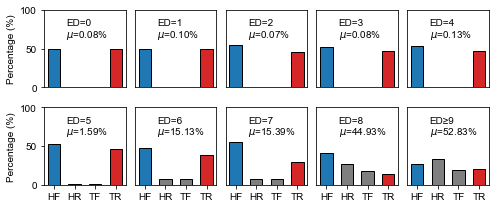

2nd barcode


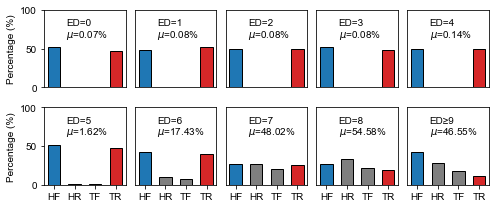

--------------------------------------------------------------------------------
20220708_GM12878R2
1st barcode


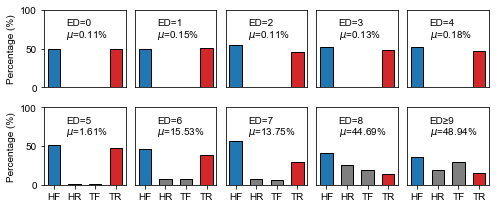

2nd barcode


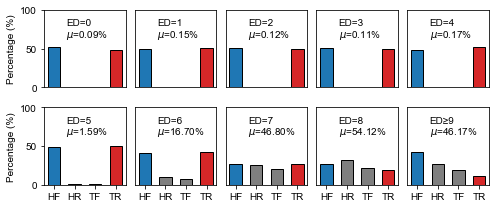

--------------------------------------------------------------------------------
20220817_HG001
1st barcode


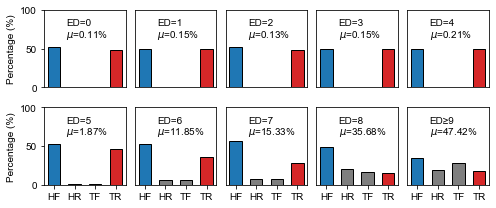

2nd barcode


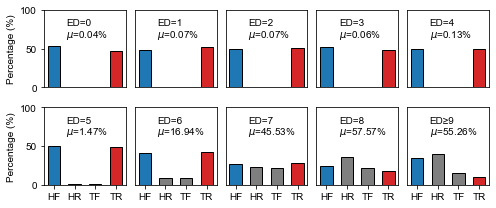

--------------------------------------------------------------------------------
20220915_P1
1st barcode


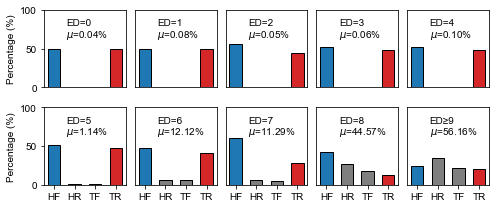

2nd barcode


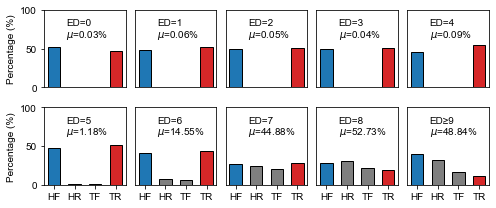

--------------------------------------------------------------------------------
20220916_P1
1st barcode


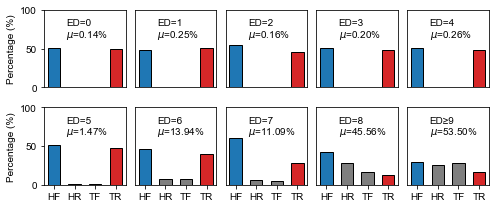

2nd barcode


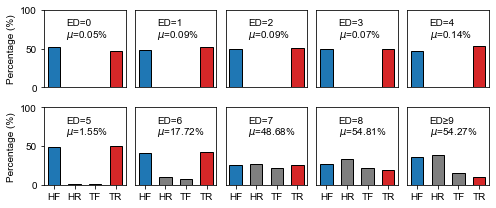

--------------------------------------------------------------------------------
20220916_P2
1st barcode


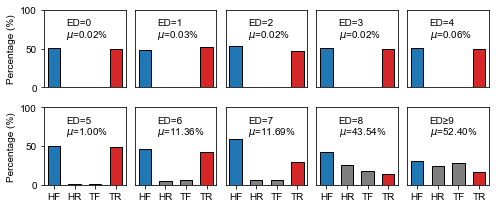

2nd barcode


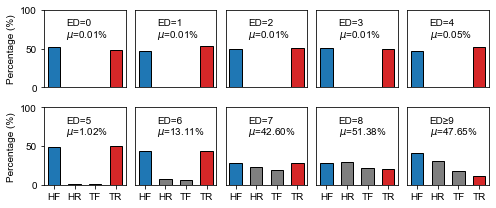

In [35]:
max_ed = 9

for run in runs:
    print("-" * 80)
    
    print(run)
    
    path = os.path.join(mtxdir, "%s.stats.tsv.gz" % run)

    d = pd.read_csv(gzip.open(path), sep="\t", header=None)
    d.columns = ["Barcode1", "Direction1", "Location1", "ED1", "Barcode2", "Direction2", "Location2", "ED2", "Count"]
    d = d[["Direction1", "Location1", "ED1", "Direction2", "Location2", "ED2", "Count"]]
    counter1 = defaultdict(int)
    counter2 = defaultdict(int)
    for direct1, loc1, ed1, direct2, loc2, ed2, count in d.values:
        assert ed1 >= 0 and ed2 >= 0
        ed1, ed2 = min(ed1, max_ed), min(ed2, max_ed)
        counter1[(ed1, direct1, loc1)] += count
        counter2[(ed2, direct2, loc2)] += count
    
    for i, counter in enumerate([counter1, counter2]):
        if i == 0:
            print("1st barcode")
        else:
            print("2nd barcode")
        nrow, ncol = 2, 5
        fig, axs = plt.subplots(nrow, ncol, figsize=(7, 3))
        
        for ed in np.arange(ncol * nrow):
            vs = []
            for loc in ["H", "T"]:
                for direct in ["F", "R"]:
                    v = counter.get((ed, direct, loc), 0)
                    vs.append(v)
            total = sum(vs)
            ys = np.array(vs) * 100 / total
            xs = np.arange(4)
            colors = ["C0", "C7", "C7", "C3"]
            
            i1 = int(ed / ncol)
            i2 = ed % ncol
            ax = axs[i1][i2]
            plt.sca(ax)
            plt.bar(xs, ys, color=colors, edgecolor="black", width=0.6)
            plt.ylim(0, 100)
            if i1 == 0:
                plt.xticks([])
            else:
                plt.xticks(xs, ["HF", "HR", "TF", "TR"])
            if i2 == 0:
                plt.ylabel("Percentage (%)")
            else:
                plt.yticks([])
            noise = 100 - (ys[0] + ys[3])
            x = 0.6
            if ed < nrow * ncol - 1:
                plt.text(x, 80, "ED=%d" % ed)
            else:
                plt.text(x, 80, "ED≥%d" % ed)
            plt.text(x, 65, "$\mu$=%.2f%%" % noise)
            plt.tight_layout(w_pad=0.5)
        
        plt.show()
        plt.close()

# Confident linker

In [36]:
# TODO

# Potential chimeric

In [37]:
# TODO